# Section 1: Data Preprocess

In [1]:
import pandas as pd

In [2]:
data=pd.read_csv('titanic_augmented.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,is_alone,ticket_group_size,fare_per_person,age_fare_ratio,cabin_deck,cabin_room_number,booking_reference,service_id,cabin_score,name_word_count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,7.250,3.034483,Unknown,NaN,92490,221958,6.134152,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,71.283,0.533084,C,85.0,15655423,771155,4.182430,7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,7.925,3.280757,Unknown,NaN,90218500,231932,9.327285,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,2,26.550,0.659134,C,123.0,2493079,465838,8.660639,7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,1,8.050,4.347826,Unknown,NaN,59517148,359178,0.452187,4


## Section 1.1: Cabin and Age Data

From the dataset, we observe that approximately 75% of the observations have missing values for the Cabin variable.
However, the data provider has already performed preprocessing by aggregating cabin-related information into the cabin_score feature.
Therefore, we use cabin_score together with a newly created cabin_missing indicator to represent cabin-related information in the analysis.

We also observe that a substantial number of passengers have missing values for Age.
Therefore, we create a new binary variable, age_missing, to explicitly capture this information.

In [4]:
len(data[data["Cabin"].isna()])

687

In [5]:
data[data["Cabin"].notna() & data['Age'].isna()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,is_alone,ticket_group_size,fare_per_person,age_fare_ratio,cabin_deck,cabin_room_number,booking_reference,service_id,cabin_score,name_word_count
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,...,0,2,73.260,0.0,B,78.0,41405837,521909,6.061746,6
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,...,1,1,35.500,0.0,C,52.0,76343490,356840,5.899177,3
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,...,0,2,11.179,0.0,F,69.0,70214072,788519,2.692432,3
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,...,0,2,27.500,0.0,E,33.0,20531130,318126,1.120389,5
185,186,0,1,"Rood, Mr. Hugh Roscoe",male,NaN,0,0,113767,50.0000,...,1,1,50.000,0.0,A,32.0,98227178,874684,6.106200,4


We can see from the dataset that there are 687 people missing Cabin information. Therefore, we decide to process the cabin information first.

In [6]:
data["Age_missing"] = data["Age"].isna()
data["Cabin_missing"] = data["Cabin"].isna()
fare_mean_table = pd.pivot_table(
    data,
    values="fare_per_person",
    index="Age_missing",
    columns="Cabin_missing",
    aggfunc="mean"
)

fare_mean_table

Cabin_missing,False,True
Age_missing,,
False,39.542481,11.450115
True,40.288526,10.835747


Given the histogram of the age column, we decide to fill the missing age data with age mean, since it is almost normally distributed.

<Axes: >

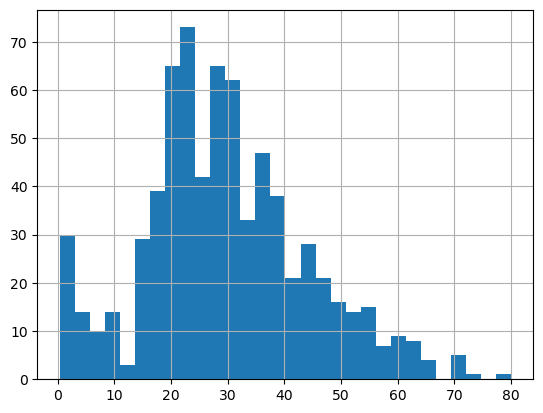

In [7]:
data['Age'].hist(bins=30)

In [8]:
data['Age'] = data['Age'].fillna(data['Age'].mean())

In [9]:
import altair as alt
alt.Chart(data).mark_bar(opacity=0.7).encode(
    x=alt.X(
        "Fare:Q",
        bin=alt.Bin(maxbins=40),
        title="Fare"
    ),
    y=alt.Y("count()", title="Count"),
    color=alt.Color(
        "Cabin_missing:N",
        title="Cabin Missing",
        scale=alt.Scale(scheme="set1")
    )
).properties(
    width=500,
    height=350,
    title="Fare Distribution by Cabin Missingness"
)


alt.Chart(...)

Note that we can see from the dataframe that passengers with Cabin information tend to pay a higher ticket price

## Section 1.2: Quantitative Data Normalization

We observe that the distributions of Fare, fare_per_person, and age_fare_ratio are highly right-skewed.
Therefore, we apply a logarithmic transformation to these variables in order to reduce skewness and make the distributions more approximately normal.

In [10]:
fare_hist = alt.Chart(data).mark_bar().encode(
    x=alt.X(
        "Fare:Q",
        bin=alt.Bin(maxbins=40),
        title="Fare"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Fare"
)

fpp_hist = alt.Chart(data[data["fare_per_person"].notna()]).mark_bar().encode(
    x=alt.X(
        "fare_per_person:Q",
        bin=alt.Bin(maxbins=40),
        title="Fare per Person"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Fare per Person"
)

afr_hist = alt.Chart(data[data["age_fare_ratio"].notna()]).mark_bar().encode(
    x=alt.X(
        "age_fare_ratio:Q",
        bin=alt.Bin(maxbins=40),
        title="Age / Fare Ratio"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Age–Fare Ratio"
)

(fare_hist | fpp_hist | afr_hist).resolve_scale(
    y="independent"
)

alt.HConcatChart(...)

In [11]:
import numpy as np
data["log_Fare"] = np.log1p(data["Fare"])
data["log_fare_per_person"] = np.log1p(data["fare_per_person"])
data["log_age_fare_ratio"] = np.log1p(data["age_fare_ratio"])

In [12]:
fare_hist = alt.Chart(data).mark_bar().encode(
    x=alt.X(
        "log_Fare:Q",
        bin=alt.Bin(maxbins=40),
        title="Fare"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Fare"
)

fpp_hist = alt.Chart(data[data["fare_per_person"].notna()]).mark_bar().encode(
    x=alt.X(
        "log_fare_per_person:Q",
        bin=alt.Bin(maxbins=40),
        title="Fare per Person"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Fare per Person"
)

afr_hist = alt.Chart(data[data["age_fare_ratio"].notna()]).mark_bar().encode(
    x=alt.X(
        "log_age_fare_ratio:Q",
        bin=alt.Bin(maxbins=40),
        title="Age / Fare Ratio"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Age–Fare Ratio"
)

(fare_hist | fpp_hist | afr_hist).resolve_scale(
    y="independent"
)

alt.HConcatChart(...)

## Section 1.4: Dropping Uneccesary Columns:

We keep cabin_score and cabin_missing as the sole representations of cabin-related information and drop all remaining cabin variables.
Furthermore, we remove the original (untransformed) variables Fare, fare_per_person, and age_fare_ratio, along with identifier variables such as PassengerID, Name, Ticket, service_id, and booking_reference, as these features do not carry predictive value and may lead to data leakage.

Given the title and title_group variables, we retain both columns for the time being.
The choice of which variable to use will be left to individual group members’ modeling decisions.
Note that title_group is a compressed version of the original title variable.

In [13]:
data=data.drop(columns=['PassengerId','Fare','fare_per_person','age_fare_ratio','Name','Ticket','service_id','booking_reference','Cabin','cabin_deck','cabin_room_number'])

In [14]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,family_size,is_alone,ticket_group_size,cabin_score,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio
0,0,3,male,22.000000,1,0,S,23,Mr,Mr,2,0,1,6.134152,4,False,True,2.110213,2.110213,1.394878
1,1,1,female,38.000000,1,0,C,51,Mrs,Mrs,2,0,1,4.182430,7,False,False,4.280593,4.280589,0.427282
2,1,3,female,26.000000,0,0,S,22,Miss,Miss,1,1,1,9.327285,3,False,True,2.188856,2.188856,1.454130
3,1,1,female,35.000000,1,0,S,44,Mrs,Mrs,2,0,2,8.660639,7,False,False,3.990834,3.316003,0.506296
4,0,3,male,35.000000,0,0,S,24,Mr,Mr,1,1,1,0.452187,4,False,True,2.202765,2.202765,1.676690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,S,21,Rev,Other,1,1,1,4.308875,3,False,True,2.639057,2.639057,1.123930
887,1,1,female,19.000000,0,0,S,28,Miss,Miss,1,1,1,2.487143,4,False,False,3.433987,3.433987,0.490623
888,0,3,female,29.699118,1,2,S,40,Miss,Miss,4,0,2,6.171450,5,True,True,3.196630,2.543569,0.000000
889,1,1,male,26.000000,0,0,C,21,Mr,Mr,1,1,1,7.067772,4,False,False,3.433987,3.433987,0.624154


In [15]:
data.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked',
       'name_length', 'title', 'title_group', 'family_size', 'is_alone',
       'ticket_group_size', 'cabin_score', 'name_word_count', 'Age_missing',
       'Cabin_missing', 'log_Fare', 'log_fare_per_person',
       'log_age_fare_ratio'],
      dtype='object')

## Section 1.5: Exporting Training and Testing Dataset

In [16]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(
    data,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=data["Survived"]
)

train_data.to_csv("train.csv", index=False)
test_data.to_csv("test.csv", index=False)